---
format:
  html:
    code-fold: true
execute:
  warning: false
---

# Trends Over Time

In this section, we explore how our selected variables change over time across the years for which they were collected. Specifically, we will explore changes in commuting frequency, bridge counts, and bridge quality. 

## Import Packages and Read Data

In [6]:
library(tidyverse)
library(sf)
library(geojsonsf)
library(leaflet)
library(tmap)
library(spData)
library(usmap)
library(dplyr)
library(ggpubr)
library(plotly)
library(ggplot2)

Warning message:
"package 'tidyverse' was built under R version 4.1.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.2.0     v stringr 1.5.0
v readr   2.1.2     v forcats 0.5.2
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'purrr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
Warning message:
"package 'stringr' was built under R version 4.1.2"
Warning message:
"package 'forcats' was built under R version 4.1.2"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Lin

In [23]:
df <- read.csv("../data/cleaned.csv", header = T)
# head(df, 3)

In [8]:
counties <- geojson_sf("../data/us_counties.geojson")

## Trip Frequency Over Time

We start by examining how travel frequency has changed nationally from 2019 to 2020. We focus on these years with a specific interest in exploring how the COVID-19 pandemic impacted commuting volumes.

In [9]:
tripFreq <- df[, c(which(colnames(df) %in% c("State","County","Year","Demographics_Population")), grep("Person.trips", names(df)))]
tripFreq$TotalTrips <- rowSums(tripFreq[, grep("Person.trips", names(tripFreq))])
tripFreq <- tripFreq[, c("State","County","Year","Demographics_Population","TotalTrips")]
# head(tripFreq)

In [10]:
pops <- tripFreq %>%
  group_by(County, State) %>%
  summarize(pops = mean(Demographics_Population, na.rm = TRUE))
tripFreq <- tripFreq %>%
  left_join(pops, by = c("County" = "County", "State" = "State"))

tripFreq <- tripFreq[complete.cases(tripFreq$TotalTrips), ]
tripFreq$TotalTrips.PerCap <- tripFreq$TotalTrips / tripFreq$pops
tripFreq <- tripFreq[, c("State","County","Year","TotalTrips.PerCap")]
# head(tripFreq)

`summarise()` has grouped output by 'County'. You can override using the
`.groups` argument.


#### Choropleths

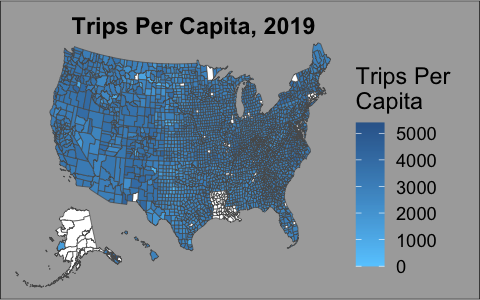

In [11]:
options(
  repr.plot.width = 4,
  repr.plot.height = 2.5
)

tf.2019 <- tripFreq %>% filter(Year == (2019))
plot.2019 <- ggplot() +
                geom_sf(data = merge(counties, tf.2019, by.x = c("county","full"), by.y = c("County","State"), all.x = TRUE),
                        aes(fill = TotalTrips.PerCap)) +
                scale_fill_gradient(name = "Trips Per\nCapita", 
                                low = "#66CCFF", high = "#336699",na.value = "white",
                                limits = c(0, 5400)) +
                theme_void() +
                theme(legend.position = "right",
                        plot.title = element_text(hjust = 0.7, size = 14, 
                                                face = "bold", color = "black", 
                                                margin = margin(t = 10, b = -5)),  # Adjust font size, face, color, and background of the plot title
                        plot.background = element_rect(fill = "#aaaaaa"),  # Set background color of the plot
                        legend.title = element_text(size = 14),  # Adjust font size of legend title
                        legend.text = element_text(size = 11),
                        legend.margin = margin(t = 0, r = 20, b = 0, l = 0)) + 
                labs(title = "Trips Per Capita, 2019")
plot.2019

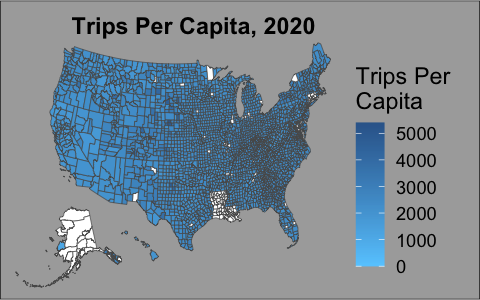

In [12]:
tf.2020 <- tripFreq %>% filter(Year == (2020))
plot.2020 <- ggplot() +
                geom_sf(data = merge(counties, tf.2020, by.x = c("county","full"), by.y = c("County","State"), all.x = TRUE),
                        aes(fill = TotalTrips.PerCap)) +
                scale_fill_gradient(name = "Trips Per\nCapita", 
                                low = "#66CCFF", high = "#336699",na.value = "white",
                                limits = c(0, 5400)) +
                theme_void() +
                theme(legend.position = "right",
                        plot.title = element_text(hjust = 0.7, size = 14, 
                                                face = "bold", color = "black", 
                                                margin = margin(t = 10, b = -5)),  # Adjust font size, face, color, and background of the plot title
                        plot.background = element_rect(fill = "#aaaaaa"),  # Set background color of the plot
                        legend.title = element_text(size = 14),  # Adjust font size of legend title
                        legend.text = element_text(size = 11),
                        legend.margin = margin(t = 0, r = 20, b = 0, l = 0)) + 
                labs(title = "Trips Per Capita, 2020")
plot.2020

#### Alluvial Trajectory Chart

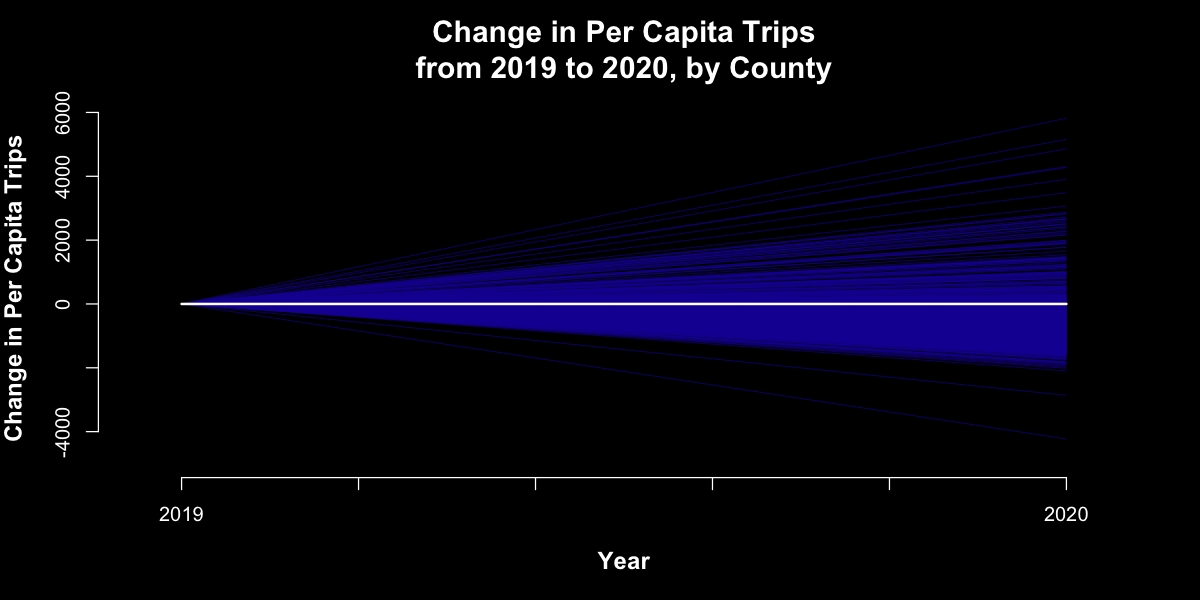

In [13]:
options(
  repr.plot.width = 10,
  repr.plot.height = 5
)

tripFreq$countyAndState <- paste(tripFreq$County,", ",tripFreq$State,sep = "")
tripFreq.wide <- pivot_wider(tripFreq[, c("countyAndState","Year","TotalTrips.PerCap")], names_from = Year, values_from = TotalTrips.PerCap, id_cols = "countyAndState")
tripFreq.wide$diff <- tripFreq.wide$'2020' - tripFreq.wide$'2019'

par(bg = "black")

plot(0, type = "n", xlim = c(2018.95, 2020.05), ylim = c(-5000,6000),
    xlab = "", ylab = "", xaxt = "n")
for (i in 1:nrow(tripFreq.wide)) {
  lines(c(2019, 2020), c(0, tripFreq.wide$diff[i]), col = "#1B03A3", lwd = 0.5)  # Plot a line for each row, with a different color
}
lines(c(2019,2020),c(0,0), col = "white", lwd = 2)

title(main = "Change in Per Capita Trips\nfrom 2019 to 2020, by County", col.main = "white", cex.main = 1.5)
title(xlab = "Year", col.lab = "white", font.lab = 2, cex.lab = 1.2)
title(ylab = "Change in Per Capita Trips", col.lab = "white", font.lab = 2, cex.lab = 1.2)

xlabs <- c("2019", "", "", "", "", "2020")
axis(1, at = seq(2019, 2020, length.out = 6), labels = xlabs, col = "white", col.axis = "white")
axis(2, col = "white", col.axis = "white")

## Bridge Count and Quality Over Time

We explore infrastructural development over time as well, by exploring how bridge counts and quality have changed within recent years across the country.

In [24]:
bridgeQual <- df[, c(which(colnames(df) %in% c("State","County","Year","Demographics_Population")), grep("Bridges_Bridges..", names(df)))]
bridgeQual$bridgeCount <- rowSums(bridgeQual[, grep("Bridges_Bridges..", names(bridgeQual))])
bridgeQual <- bridgeQual %>%
  mutate(qualityScore = (Bridges_Bridges..poor + (2*Bridges_Bridges..fair) + (3*Bridges_Bridges..good))/bridgeCount)
# head(bridgeQual)

In [25]:
bridgeQual <- bridgeQual[complete.cases(bridgeQual$bridgeCount), ]
# head(bridgeQual)

In [26]:
bridgeQual <- bridgeQual[order(bridgeQual$State, bridgeQual$County, bridgeQual$Year), ]
bridgeQual <- bridgeQual %>%
  group_by(County, State) %>%
  fill(Demographics_Population)

bridgeQual$bridgesPer1000 <- (bridgeQual$bridgeCount / bridgeQual$Demographics_Population)*1000
bridgeQual <- bridgeQual[, c("State","County","Year","bridgesPer1000","qualityScore")]
# head(bridgeQual)

In [27]:
options(
  repr.plot.width = 8,
  repr.plot.height = 5.2
)

plotBridgePer1000 <- function(year){
        bq <- bridgeQual %>% filter(Year == year)
        bq.plot <- ggplot() +
                        geom_sf(data = merge(counties, bq, by.x = c("county","full"), by.y = c("County","State"), all.x = TRUE),
                                aes(fill = bridgesPer1000)) +
                        scale_fill_gradient(name = "Bridges Per\n1000 People", 
                                        low = "#fbefae", high = "#FF6600",na.value = "white",
                                        limits = c(0, 20)) +
                        theme_void() +
                        theme(legend.position = "right",
                                plot.title = element_text(hjust = 0.7, size = 20, 
                                                        face = "bold", color = "black", 
                                                        margin = margin(t = 10, b = -20)),
                                plot.background = element_rect(fill = "#aaaaaa"),
                                legend.title = element_text(size = 14),
                                legend.text = element_text(size = 11),
                                legend.margin = margin(t = 0, r = 0, b = 0, l = -40)) + 
                        labs(title = paste("Bridges Per 1000 People, ",year))
        return(bq.plot)
}

plotQualityScores <- function(year){
        bq <- bridgeQual %>% filter(Year == year)
        bq.plot <- ggplot() +
                        geom_sf(data = merge(counties, bq, by.x = c("county","full"), by.y = c("County","State"), all.x = TRUE),
                                aes(fill = qualityScore)) +
                        scale_fill_gradient2(name = "Average Bridge Quality Score", 
                                        mid = "red", high = "green",na.value = "white",
                                        limits = c(1, 3)) +
                        theme_void() +
                        theme(legend.position = "right",
                                plot.title = element_text(hjust = 0.7, size = 20, 
                                                        face = "bold", color = "black", 
                                                        margin = margin(t = 10, b = -20)),
                                plot.background = element_rect(fill = "#aaaaaa"),
                                legend.title = element_text(size = 14),
                                legend.text = element_text(size = 11),
                                legend.margin = margin(t = 0, r = 20, b = 0, l = 0)) + 
                        labs(title = paste("Average Bridge Quality Score, ",year))
        return(bq.plot)
}

#### Choropleths of Bridge Count Over Time

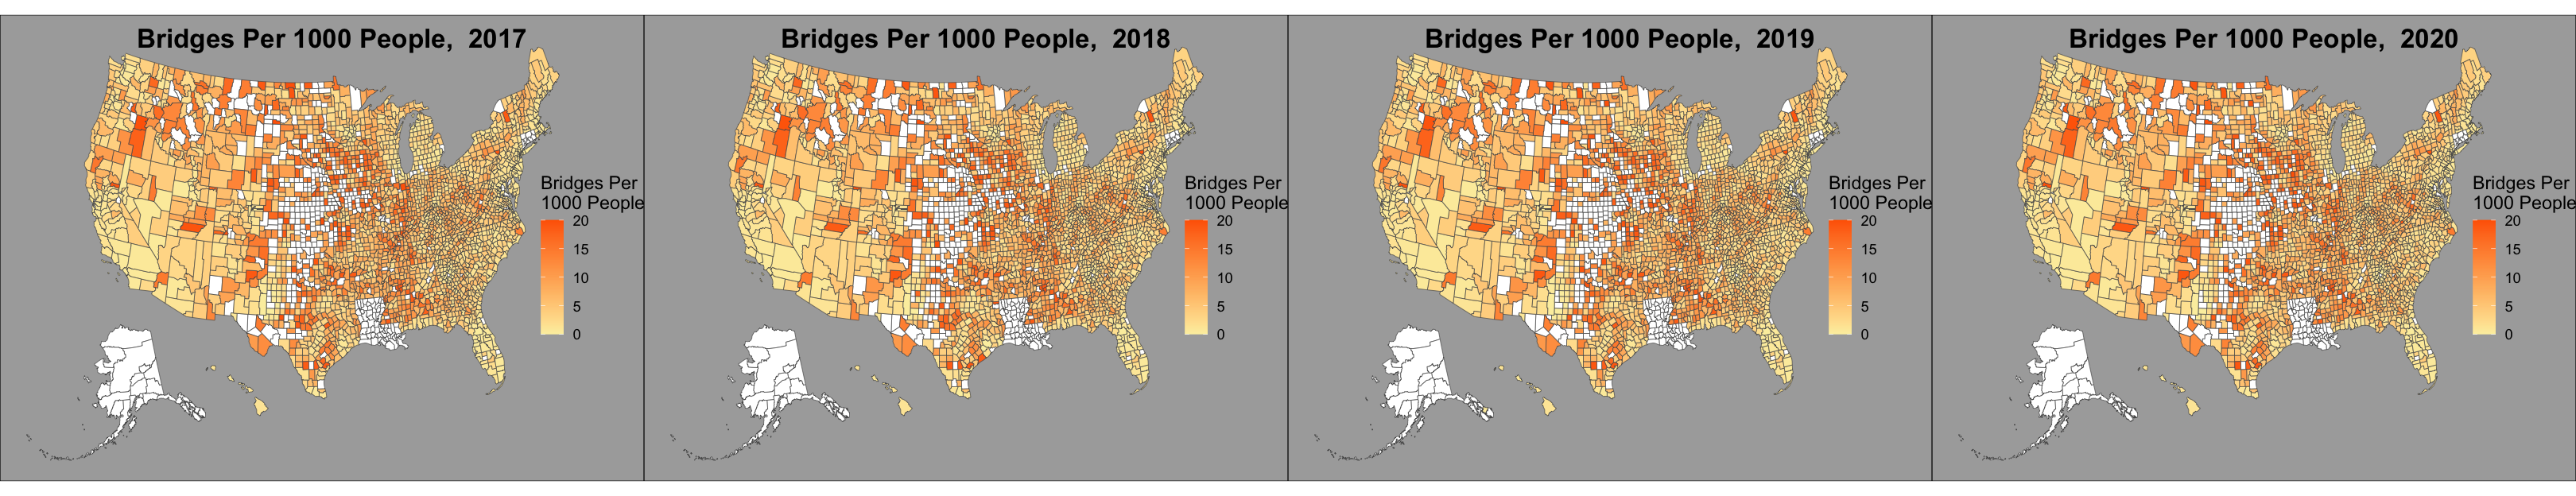

In [28]:
options(
  repr.plot.width = 27,
  repr.plot.height = 5.2
)

ggarrange(plotBridgePer1000(2017),
            plotBridgePer1000(2018),
            plotBridgePer1000(2019),
            plotBridgePer1000(2020),
           ncol = 4)

#### Change in Bridge

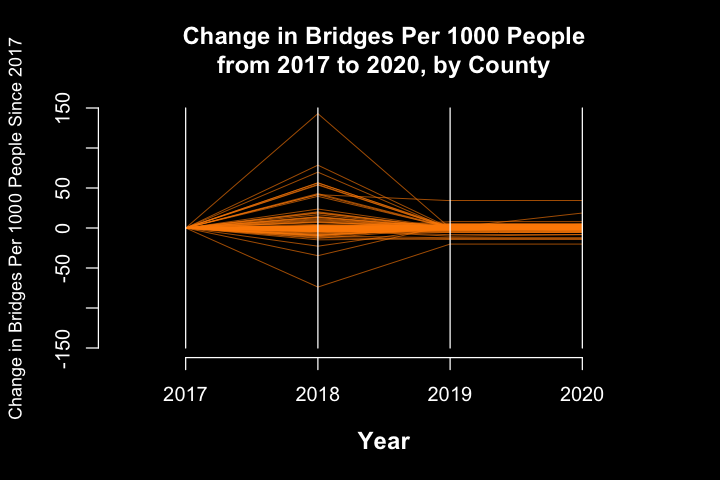

In [20]:
options(
  repr.plot.width = 6,
  repr.plot.height = 4
)

bridgeQual$countyAndState <- paste(bridgeQual$County,", ",bridgeQual$State,sep = "")
bridgeQual.wide <- pivot_wider(bridgeQual[, c("countyAndState","Year","bridgesPer1000")], names_from = Year, values_from = bridgesPer1000, id_cols = "countyAndState")

bridgeQual.wide$diff.2018 <- bridgeQual.wide$'2018' - bridgeQual.wide$'2017'
bridgeQual.wide$diff.2019 <- bridgeQual.wide$'2019' - bridgeQual.wide$'2017'
bridgeQual.wide$diff.2020 <- bridgeQual.wide$'2020' - bridgeQual.wide$'2017'

par(bg = "black")

plot(0, type = "n", xlim = c(2016.5, 2020.5), ylim = c(-150,150),
    xlab = "", ylab = "", xaxt = "n")
for (i in 1:nrow(bridgeQual.wide)) {
  lines(c(2017, 2018), c(0, bridgeQual.wide$diff.2018[i]), col = "darkorange", lwd = 0.5)
  lines(c(2018, 2019), c(bridgeQual.wide$diff.2018[i], bridgeQual.wide$diff.2019[i]), col = "darkorange", lwd = 0.5)
  lines(c(2019, 2020), c(bridgeQual.wide$diff.2019[i], bridgeQual.wide$diff.2020[i]), col = "darkorange", lwd = 0.5)
}

lines(c(2017,2017),c(-150,150), col = "white", lwd = 1)
lines(c(2018,2018),c(-150,150), col = "white", lwd = 1)
lines(c(2019,2019),c(-150,150), col = "white", lwd = 1)
lines(c(2020,2020),c(-150,150), col = "white", lwd = 1)

title(main = "Change in Bridges Per 1000 People\nfrom 2017 to 2020, by County", col.main = "white", cex.main = 1.2)
title(xlab = "Year", col.lab = "white", font.lab = 2, cex.lab = 1.2)
title(ylab = "Change in Bridges Per 1000 People Since 2017", col.lab = "white", cex.lab = 0.9)

xlabs <- c("2017","2018","2019","2020")
axis(1, at = seq(2017, 2020, length.out = 4), labels = xlabs, col = "white", col.axis = "white")
axis(2, col = "white", col.axis = "white")

#### Choropleths of Bridge Count Over Time

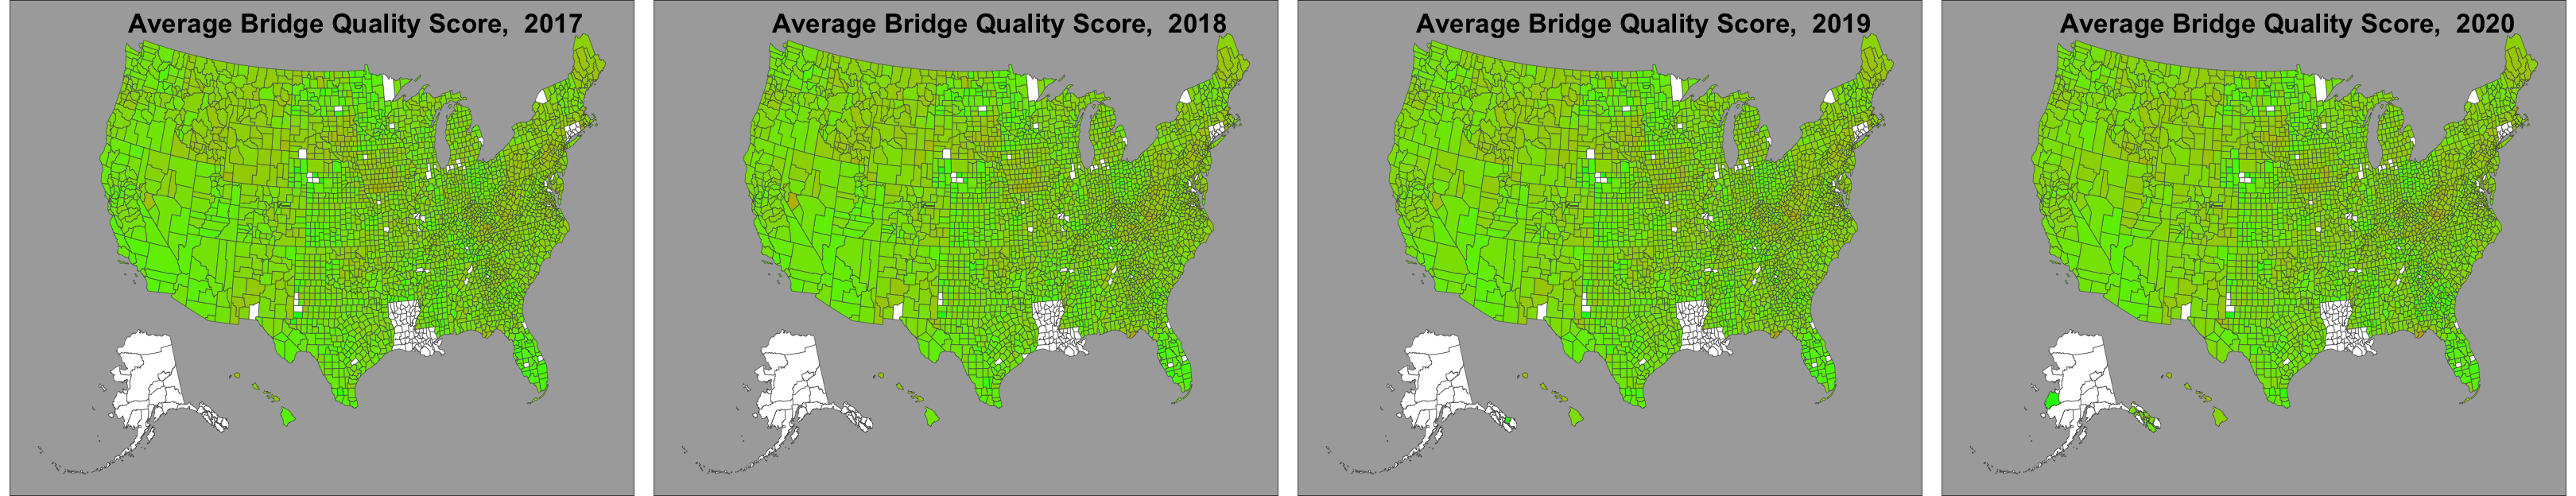

In [21]:
options(
  repr.plot.width = 27,
  repr.plot.height = 5.2
)

ggarrange(plotQualityScores(2017) + theme(legend.position = "none"),
            plotQualityScores(2018) + theme(legend.position = "none"),
            plotQualityScores(2019) + theme(legend.position = "none"),
            plotQualityScores(2020) + theme(legend.position = "none"),
           ncol = 4)

#### Bar Graph of Quality Proportions Over Time

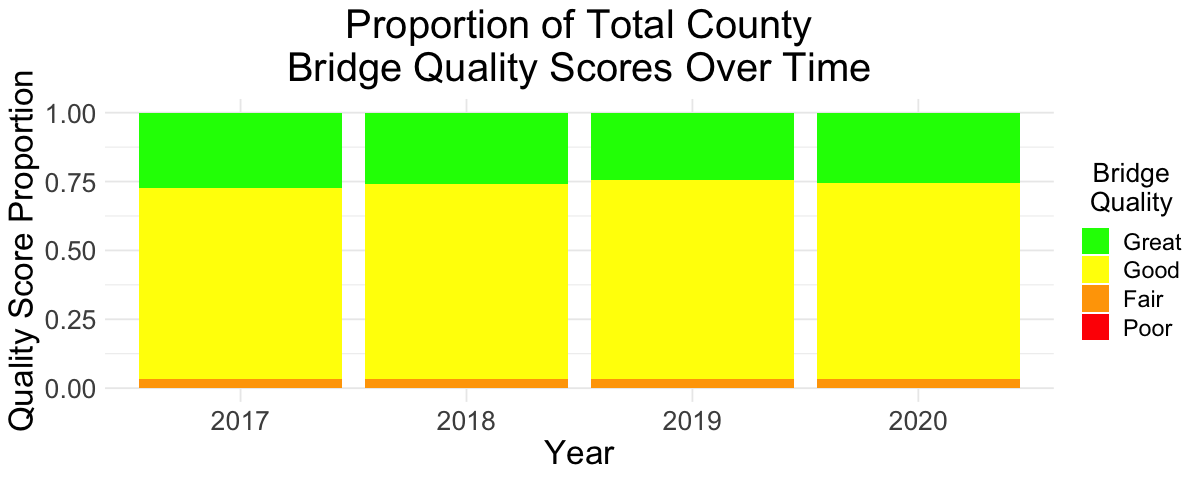

In [22]:
options(
  repr.plot.width = 10,
  repr.plot.height = 4
)

bins <- c(1, 1.5, 2, 2.5, 3)

qualBins <- c("Poor", "Fair", "Good", "Great")

bridgeQual$scoreBin <- cut(bridgeQual$qualityScore, breaks = bins, labels = qualBins)
barChart <- table(bridgeQual$Year, bridgeQual$scoreBin)
barDf <- as.data.frame.matrix(barChart)
totals <- rowSums(barDf)

barDf$Year <- rownames(barDf)
rownames(barDf) <- NULL

for(c in qualBins){
    barDf[c] <- barDf[c] / totals
}
barDf <- gather(barDf, key = "scoreBin", value = "Proportion", -Year)

barDf$scoreBin <- factor(barDf$scoreBin, levels = c("Great","Good","Fair","Poor"))

ggplot(barDf, aes(x = Year, y = Proportion, fill = scoreBin)) +
  geom_bar(stat = "identity") +
  labs(x = "Year", y = "Quality Score Proportion", fill = "Bridge\nQuality",
  title = "Proportion of Total County\nBridge Quality Scores Over Time") +
  scale_fill_manual(values = c("green", "yellow", "orange", "red")) +
  theme_minimal() + 
  theme(
    plot.title = element_text(hjust = 0.5, size = 24),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    legend.title = element_text(hjust = 0.5, size = 16),
    legend.text = element_text(size = 14),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16)
  )